    #### INITIAL DISTRIBUTION: TWO MODES ####
    θ_v_1 = 1000.0
    N_1   = 10.0
    k_1   = 4
    θ_v_2 = 200.0
    N_2   = 100.0
    k_2   = 2

## PySDM

In [1]:
import sys, os
os.environ["NUMBA_DISABLE_JIT"] = "1"

import numpy as np

from PySDM.backends import CPU
from PySDM.builder import Builder
from PySDM.environments import Box
from PySDM.dynamics import Collision
from PySDM.initialisation.sampling.spectral_sampling import ConstantMultiplicity, UniformRandom

from PySDM.products.size_spectral import ParticleVolumeVersusRadiusLogarithmSpectrum, ParticleSizeSpectrumPerVolume
import PySDM.products.size_spectral.arbitrary_moment as am
from PySDM.products.housekeeping.timers import WallTime

from matplotlib import pyplot

from PySDM.initialisation.spectra import Gamma, Exponential, Sum
from PySDM.dynamics.collisions.collision_kernels import SimpleGeometric
from PySDM.dynamics.collisions.coalescence_efficiencies import ConstEc
from PySDM.dynamics.collisions.breakup_efficiencies import ConstEb
from PySDM.dynamics.collisions.breakup_fragmentations import AlwaysN
from PySDM.physics.constants import si
from PySDM.physics.constants_defaults import rho_w, rho_STP
from PySDM import Formulae
from pystrict import strict

from numba import config, threading_layer
config.THREADING_LAYER = 'default'

from scipy.stats import gamma

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return (idx, array[idx])

In [3]:
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**15
        self.dv = 1 * si.m**3

        self.n_part1 = 10 / si.cm**3
        self.k1 = 4
        self.theta1 = 1000 * si.um**3
        self.n_part2 = 100 / si.cm**3
        self.k2 = 2
        self.theta2 = 200 * si.um**3
        
        self.norm_factor1 = self.n_part1 * self.dv
        self.norm_factor2 = self.n_part2 * self.dv
        self.spectrum1 = Gamma(norm_factor=self.norm_factor1, theta=self.theta1, k=self.k1)
        self.spectrum2 = Gamma(norm_factor=self.norm_factor2, theta=self.theta2, k=self.k2)
        self.spectrum = Sum((self.spectrum1, self.spectrum2))

        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 600 * si.seconds
        self.adaptive = False
        self.seed = 44
        self._steps = [0, 4*3600.0]
        self.kernel = SimpleGeometric(C=np.pi * 1e-12 * si.cm**3 / si.um**4 / si.s)
        self.coal_eff = ConstEc(Ec=1.0)
        self.fragmentation = AlwaysN(n=1)
        self.break_eff = ConstEb(0.0) # no "bouncing"
        
        self.radius_bins_edges = np.logspace(np.log10(1 * si.um), np.log10(1000 * si.um), num=128, endpoint=True)
        self.volume_bins_edges = self.radius_bins_edges**3 * 4 * np.pi / 3
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

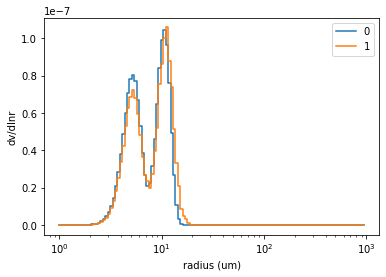

In [4]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend(settings.formulae))
env = Box(dv=settings.dv, dt=settings.dt)
builder.set_environment(env)
env['rhod'] = 1.00 * si.kg / si.m**3
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Collision(collision_kernel = settings.kernel, coalescence_efficiency=settings.coal_eff, breakup_efficiency=settings.break_eff, 
    fragmentation_function=settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
# env['rhod'] = 1
dvdlnr = ParticleVolumeVersusRadiusLogarithmSpectrum(radius_bins_edges=settings.radius_bins_edges, name='dv/dlnr')
nv = ParticleSizeSpectrumPerVolume(radius_bins_edges=settings.radius_bins_edges, name='N(v)')
products = [dvdlnr, nv]
core = builder.build(attributes, products)
sdm_y = np.zeros((len(settings.radius_bins_edges)-1,len(settings.output_steps)))
sdm_y1 = np.zeros((len(settings.radius_bins_edges)-1,len(settings.output_steps)))
sdm_x = settings.radius_bins_edges[:-1]**3 * 4 * np.pi / 3 / si.um**3
i = 0
v_cutoff = 1e3
bin_cutoff = find_nearest(sdm_x, v_cutoff)[0]
dr = settings.radius_bins_edges[1:] - settings.radius_bins_edges[:-1]
for step in settings.output_steps:
    core.run(step - core.n_steps)
    sdm_y[:,i] = core.products['N(v)'].get() * si.cm**3 * dr
    sdm_y1[:,i] = core.products['dv/dlnr'].get()[0]
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.um, 
            y=sdm_y1[:,i],
            where='post', label="t = {step*settings.dt}s")
    i += 1
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dv/dlnr")
pyplot.legend([0, 1, 2])
#pyplot.xlim([1e1, 1e6])

In [5]:
dlnr = np.mean(np.log(settings.radius_bins_edges[1:]) - np.log(settings.radius_bins_edges[:-1]))

In [6]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend(settings.formulae))
env = Box(dv=settings.dv, dt=settings.dt)
builder.set_environment(env)
env['rhod'] = 1.00 * si.kg / si.m**3
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd) #UniformRandom(settings.spectrum).sample(settings.n_sd)
breakup = Collision(collision_kernel = settings.kernel, coalescence_efficiency=settings.coal_eff, breakup_efficiency=settings.break_eff, 
    fragmentation_function=settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)

M0 = am.make_arbitrary_moment_product(rank=0, attr='volume', attr_unit='dimensionless')(name='M0')
M1 = am.make_arbitrary_moment_product(rank=1, attr='volume', attr_unit='m^3')(name='M1')
M2 = am.make_arbitrary_moment_product(rank=2, attr='volume', attr_unit='m^6')(name='M2')
Nv = ParticleSizeSpectrumPerVolume(radius_bins_edges=settings.radius_bins_edges, name='N(v)')
dvdlnr = ParticleVolumeVersusRadiusLogarithmSpectrum(radius_bins_edges=settings.radius_bins_edges, name='dv/dlnr')
products = [M0, M1, M2, Nv, dvdlnr]
core = builder.build(attributes, products)
sdm_x = settings.radius_bins_edges[:-1]**3 * 4 * np.pi / 3 / si.um**3
dx_sdm = np.diff(np.append([0.0], sdm_x))

r_cutoff = 25
v_cutoff = 4/3*np.pi*r_cutoff**3
bin_cutoff = find_nearest(sdm_x, v_cutoff)[0]

mom0 = np.zeros(int(settings._steps[-1]/settings.dt))
mom1 = np.zeros(int(settings._steps[-1]/settings.dt))
mom2 = np.zeros(int(settings._steps[-1]/settings.dt))
sdm_precip = np.zeros(int(settings._steps[-1]/settings.dt))
i = 0
for step in range(int(settings._steps[-1]/settings.dt)):
    core.run(step - core.n_steps)
    mom0[i] = M0.get()
    mom1[i] = M1.get() 
    mom2[i] = M2.get()
    dvdlnr_instant = core.products['dv/dlnr'].get()[0] * si.cm**3 / si.um**3
    mv_instant = dvdlnr_instant*dlnr

    sdm_precip[i] = np.sum(mv_instant[bin_cutoff:])
    i += 1
times_sdm = range(0,int(settings._steps[-1]),int(settings.dt))


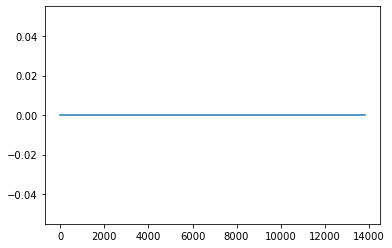

In [7]:
pyplot.plot(times_sdm, sdm_precip)

## Bin

In [8]:
# geometric_bimodal
# Tmax, nbin, dt, scal, emin, rhow, A, k1, theta, N0 
# [14400.0, 32, 5.0, 1, 7.091336e-10, 1e-09, 0.0001, 4, 1000, 10]

v_grid = [1.06370040e+00, 2.12740080e+00, 4.25480160e+00, 8.50960320e+00,
 1.70192064e+01, 3.40384128e+01, 6.80768256e+01, 1.36153651e+02,
 2.72307302e+02, 5.44614605e+02, 1.08922921e+03, 2.17845842e+03,
 4.35691684e+03, 8.71383368e+03, 1.74276674e+04, 3.48553347e+04,
 6.97106694e+04, 1.39421339e+05, 2.78842678e+05, 5.57685355e+05,
 1.11537071e+06, 2.23074142e+06, 4.46148284e+06, 8.92296569e+06,
 1.78459314e+07, 3.56918627e+07, 7.13837255e+07, 1.42767451e+08,
 2.85534902e+08, 5.71069804e+08, 1.14213961e+09, 2.28427922e+09]
r_grid = [6.33252487e-01, 7.97848139e-01, 1.00522566e+00, 1.26650497e+00,
 1.59569628e+00, 2.01045133e+00, 2.53300995e+00, 3.19139256e+00,
 4.02090266e+00, 5.06601990e+00, 6.38278511e+00, 8.04180532e+00,
 1.01320398e+01, 1.27655702e+01, 1.60836106e+01, 2.02640796e+01,
 2.55311404e+01, 3.21672213e+01, 4.05281592e+01, 5.10622809e+01,
 6.43344425e+01, 8.10563184e+01, 1.02124562e+02, 1.28668885e+02,
 1.62112637e+02, 2.04249124e+02, 2.57337770e+02, 3.24225274e+02,
 4.08498247e+02, 5.14675540e+02, 6.48450547e+02, 8.16996494e+02]

gr0 = [8.97861677e-003, 7.14479261e-002, 5.65535701e-001, 4.42905267e+000,
 3.39564697e+001, 2.49491685e+002, 1.68358081e+003, 9.58306636e+003,
 3.88146017e+004, 7.97023963e+004, 4.43805294e+004, 2.92153418e+004,
 1.00619543e+005, 4.12711389e+004, 2.16983420e+002, 1.87428989e-004,
 4.37025938e-018, 7.42502868e-047, 6.69776647e-106, 1.70311414e-225,
 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000]
gr36 = [8.73774065e-003, 6.94738925e-002, 5.49299898e-001, 4.29619545e+000,
 3.28878630e+001, 2.41254408e+002, 1.62576138e+003, 9.24838275e+003,
 3.74806882e+004, 7.71651329e+004, 4.35674928e+004, 2.85927837e+004,
 1.00148537e+005, 4.62415666e+004, 1.41097400e+003, 1.52643959e+001,
 5.60547415e-002, 9.08037823e-005, 1.47897574e-009, 1.73047084e-286,
 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000]
gr144 = [8.03130741e-03, 6.36990479e-02, 5.01958113e-01, 3.91021863e+00,
 2.97952760e+01, 2.17496800e+02, 1.45927793e+03, 8.28246572e+03,
 3.36007653e+04, 6.96498115e+04, 4.08496074e+04, 2.65992568e+04,
 9.72352910e+04, 5.95635335e+04, 7.75478577e+03, 5.11681971e+02,
 1.71196389e+01, 3.28481323e-01, 4.37932216e-03, 6.64323335e-06,
 6.74345667e-12, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]
t_bott = [    0.,   100.,   200.,   300.,   400.,   500.,   600.,   700.,   800.,
   900.,  1000.,  1100.,  1200.,  1300.,  1400.,  1500.,  1600.,  1700.,
  1800.,  1900.,  2000.,  2100.,  2200.,  2300.,  2400.,  2500.,  2600.,
  2700.,  2800.,  2900.,  3000.,  3100.,  3200.,  3300.,  3400.,  3500.,
  3600.,  3700.,  3800.,  3900.,  4000.,  4100.,  4200.,  4300.,  4400.,
  4500.,  4600.,  4700.,  4800.,  4900.,  5000.,  5100.,  5200.,  5300.,
  5400.,  5500.,  5600.,  5700.,  5800.,  5900.,  6000.,  6100.,  6200.,
  6300.,  6400.,  6500.,  6600.,  6700.,  6800.,  6900.,  7000.,  7100.,
  7200.,  7300.,  7400.,  7500.,  7600.,  7700.,  7800.,  7900.,  8000.,
  8100.,  8200.,  8300.,  8400.,  8500.,  8600.,  8700.,  8800.,  8900.,
  9000.,  9100.,  9200.,  9300.,  9400.,  9500.,  9600.,  9700.,  9800.,
  9900., 10000., 10100., 10200., 10300., 10400., 10500., 10600., 10700.,
 10800., 10900., 11000., 11100., 11200., 11300., 11400., 11500., 11600.,
 11700., 11800., 11900., 12000., 12100., 12200., 12300., 12400., 12500.,
 12600., 12700., 12800., 12900., 13000., 13100., 13200., 13300., 13400.,
 13500., 13600., 13700., 13800., 13900., 14000., 14100., 14200., 14300.,
 14400.]
M0_bott = [109.98399358, 109.89596825, 109.80795038, 109.71994023, 109.63193798,
 109.5439438 , 109.45595786, 109.36798028, 109.2800112 , 109.19205072,
 109.10409897, 109.01615603, 108.92822201, 108.84029699, 108.75238105,
 108.66447428, 108.57657675, 108.48868853, 108.40080969, 108.3129403 ,
 108.22508042, 108.13723011, 108.04938944, 107.96155846, 107.87373722,
 107.78592578, 107.69812419, 107.61033251, 107.52255078, 107.43477905,
 107.34701738, 107.2592658 , 107.17152436, 107.08379312, 106.9960721 ,
 106.90836137, 106.82066095, 106.73297089, 106.64529124, 106.55762203,
 106.46996331, 106.38231511, 106.29467748, 106.20705045, 106.11943406,
 106.03182835, 105.94423336, 105.85664913, 105.76907569, 105.68151307,
 105.59396133, 105.50642048, 105.41889058, 105.33137164, 105.24386372,
 105.15636684, 105.06888104, 104.98140635, 104.89394281, 104.80649045,
 104.71904931, 104.63161942, 104.54420081, 104.45679352, 104.36939758,
 104.28201302, 104.19463988, 104.10727819, 104.01992799, 103.93258929,
 103.84526215, 103.75794658, 103.67064263, 103.58335032, 103.49606968,
 103.40880076, 103.32154357, 103.23429815, 103.14706454, 103.05984276,
 102.97263285, 102.88543483, 102.79824874, 102.71107461, 102.62391247,
 102.53676235, 102.44962429, 102.3624983 , 102.27538443, 102.18828271,
 102.10119315, 102.01411581, 101.9270507 , 101.83999785, 101.7529573 ,
 101.66592908, 101.57891321, 101.49190974, 101.40491867, 101.31794006,
 101.23097392, 101.14402029, 101.05707919, 100.97015066, 100.88323473,
 100.79633142, 100.70944077, 100.62256281, 100.53569756, 100.44884505,
 100.36200532, 100.27517838, 100.18836429, 100.10156305, 100.01477471,
  99.92799928,  99.8412368 ,  99.75448731,  99.66775082,  99.58102737,
  99.49431698,  99.40761969,  99.32093552,  99.23426451,  99.14760668,
  99.06096205,  98.97433067,  98.88771256,  98.80110774,  98.71451625,
  98.62793811,  98.54137336,  98.45482202,  98.36828411,  98.28175968,
  98.19524874,  98.10875133,  98.02226748,  97.9357972 ,  97.84934054,
  97.76289751,  97.67646816,  97.5900525 ,  97.50365056,  97.41726238]
M1_bott = [79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176048, 79891.15176048, 79891.15176048, 79891.15176048,
 79891.15176048, 79891.15176048, 79891.15176048, 79891.15176048,
 79891.15176048, 79891.15176048, 79891.15176047, 79891.15176047,
 79891.15176047, 79891.15176047, 79891.15176046, 79891.15176046,
 79891.15176046, 79891.15176046, 79891.15176046, 79891.15176046,
 79891.15176046, 79891.15176046, 79891.15176046, 79891.15176046,
 79891.15176046, 79891.15176046, 79891.15176046, 79891.15176046,
 79891.15176046, 79891.15176046, 79891.15176046, 79891.15176046,
 79891.15176046, 79891.15176046, 79891.15176046, 79891.15176046,
 79891.15176046, 79891.15176046, 79891.15176046, 79891.15176046,
 79891.15176046, 79891.15176046, 79891.15176046, 79891.15176046,
 79891.15176046, 79891.15176046, 79891.15176046, 79891.15176046,
 79891.15176046, 79891.15176046, 79891.15176046, 79891.15176046,
 79891.15176046, 79891.15176046, 79891.15176046, 79891.15176046,
 79891.15176046, 79891.15176046, 79891.15176046, 79891.15176046,
 79891.15176046, 79891.15176046, 79891.15176046, 79891.15176046,
 79891.15176046, 79891.15176045, 79891.15176045, 79891.15176045,
 79891.15176045, 79891.15176045, 79891.15176045, 79891.15176045,
 79891.15176045, 79891.15176045, 79891.15176044, 79891.15176044,
 79891.15176044, 79891.15176044, 79891.15176044, 79891.15176043,
 79891.15176043, 79891.15176043, 79891.15176043, 79891.15176042,
 79891.15176042, 79891.15176042, 79891.15176041, 79891.15176041,
 79891.1517604 , 79891.1517604 , 79891.15176039, 79891.15176039,
 79891.15176038, 79891.15176038, 79891.15176037, 79891.15176036,
 79891.15176036, 79891.15176036, 79891.15176036, 79891.15176036,
 79891.15176036, 79891.15176036, 79891.15176036, 79891.15176036,
 79891.15176036, 79891.15176036, 79891.15176036, 79891.15176036,
 79891.15176036]
M2_bott = [2.23930994e+08, 2.24284423e+08, 2.24639292e+08, 2.24995558e+08,
 2.25353194e+08, 2.25712179e+08, 2.26072493e+08, 2.26434122e+08,
 2.26797052e+08, 2.27161271e+08, 2.27526768e+08, 2.27893535e+08,
 2.28261564e+08, 2.28630848e+08, 2.29001379e+08, 2.29373154e+08,
 2.29746167e+08, 2.30120413e+08, 2.30495890e+08, 2.30872593e+08,
 2.31250521e+08, 2.31629671e+08, 2.32010040e+08, 2.32391628e+08,
 2.32774433e+08, 2.33158453e+08, 2.33543689e+08, 2.33930139e+08,
 2.34317803e+08, 2.34706682e+08, 2.35096775e+08, 2.35488083e+08,
 2.35880606e+08, 2.36274346e+08, 2.36669301e+08, 2.37065475e+08,
 2.37462868e+08, 2.37861481e+08, 2.38261315e+08, 2.38662373e+08,
 2.39064655e+08, 2.39468164e+08, 2.39872902e+08, 2.40278870e+08,
 2.40686071e+08, 2.41094506e+08, 2.41504178e+08, 2.41915090e+08,
 2.42327244e+08, 2.42740642e+08, 2.43155287e+08, 2.43571181e+08,
 2.43988328e+08, 2.44406731e+08, 2.44826391e+08, 2.45247313e+08,
 2.45669499e+08, 2.46092952e+08, 2.46517676e+08, 2.46943673e+08,
 2.47370948e+08, 2.47799503e+08, 2.48229342e+08, 2.48660468e+08,
 2.49092885e+08, 2.49526597e+08, 2.49961606e+08, 2.50397918e+08,
 2.50835535e+08, 2.51274461e+08, 2.51714701e+08, 2.52156258e+08,
 2.52599136e+08, 2.53043339e+08, 2.53488872e+08, 2.53935737e+08,
 2.54383940e+08, 2.54833485e+08, 2.55284376e+08, 2.55736616e+08,
 2.56190212e+08, 2.56645166e+08, 2.57101483e+08, 2.57559169e+08,
 2.58018226e+08, 2.58478661e+08, 2.58940477e+08, 2.59403679e+08,
 2.59868272e+08, 2.60334260e+08, 2.60801649e+08, 2.61270443e+08,
 2.61740646e+08, 2.62212265e+08, 2.62685304e+08, 2.63159767e+08,
 2.63635660e+08, 2.64112989e+08, 2.64591757e+08, 2.65071970e+08,
 2.65553634e+08, 2.66036754e+08, 2.66521334e+08, 2.67007381e+08,
 2.67494899e+08, 2.67983894e+08, 2.68474372e+08, 2.68966337e+08,
 2.69459796e+08, 2.69954754e+08, 2.70451217e+08, 2.70949190e+08,
 2.71448679e+08, 2.71949689e+08, 2.72452227e+08, 2.72956299e+08,
 2.73461909e+08, 2.73969065e+08, 2.74477771e+08, 2.74988035e+08,
 2.75499861e+08, 2.76013257e+08, 2.76528228e+08, 2.77044780e+08,
 2.77562920e+08, 2.78082653e+08, 2.78603987e+08, 2.79126927e+08,
 2.79651479e+08, 2.80177651e+08, 2.80705449e+08, 2.81234879e+08,
 2.81765947e+08, 2.82298661e+08, 2.82833026e+08, 2.83369050e+08,
 2.83906740e+08, 2.84446101e+08, 2.84987142e+08, 2.85529868e+08,
 2.86074287e+08, 2.86620405e+08, 2.87168230e+08, 2.87717769e+08,
 2.88269028e+08]
mprecip_bin = [1.71554590e-47, 5.27408223e-13, 1.01909375e-11, 5.56280139e-11,
 1.81964616e-10, 4.50637900e-10, 9.37503694e-10, 1.73163288e-09,
 3.80197128e-09, 9.03380847e-09, 1.79814131e-08, 3.21426367e-08,
 5.33889674e-08, 8.40184393e-08, 1.26812846e-07, 1.85099132e-07,
 2.62815007e-07, 3.64578854e-07, 4.95764076e-07, 6.62577960e-07,
 8.72145225e-07, 1.13259635e-06, 1.45316083e-06, 1.84426550e-06,
 2.31763807e-06, 2.88641594e-06, 3.56526055e-06, 4.37047728e-06,
 5.32014119e-06, 6.43422859e-06, 7.73475467e-06, 9.24591735e-06,
 1.09942474e-05, 1.30087653e-05, 1.53211442e-05, 1.79658804e-05,
 2.09804703e-05, 2.44055943e-05, 2.82853089e-05, 3.26672449e-05,
 3.76028142e-05, 4.31474242e-05, 4.93606997e-05, 5.63067131e-05,
 6.40542232e-05, 7.26769222e-05, 8.22536907e-05, 9.28688626e-05,
 1.04612498e-04, 1.17580666e-04, 1.31875916e-04, 1.47610591e-04,
 1.64897344e-04, 1.83859174e-04, 2.04626623e-04, 2.27338115e-04,
 2.52140306e-04, 2.79188446e-04, 3.08646743e-04, 3.40688749e-04,
 3.75497752e-04, 4.13267178e-04, 4.54201005e-04, 4.98514193e-04,
 5.46433118e-04, 5.98196027e-04, 6.54053494e-04, 7.14268904e-04,
 7.79118930e-04, 8.48894044e-04, 9.23899020e-04, 1.00445347e-03,
 1.09089237e-03, 1.18356664e-03, 1.28284368e-03, 1.38910797e-03,
 1.50276166e-03, 1.62422519e-03, 1.75393788e-03, 1.89235863e-03,
 2.03996652e-03, 2.19726151e-03, 2.36476510e-03, 2.54302106e-03,
 2.73259614e-03, 2.93408080e-03, 3.14808993e-03, 3.37526367e-03,
 3.61626817e-03, 3.87179637e-03, 4.14256887e-03, 4.42933469e-03,
 4.73287219e-03, 5.05398991e-03, 5.39352748e-03, 5.75235650e-03,
 6.13138147e-03, 6.53154077e-03, 6.95380759e-03, 7.39919093e-03,
 7.86873659e-03, 8.36352822e-03, 8.88468832e-03, 9.43337935e-03,
 1.00108048e-02, 1.06182103e-02, 1.12568847e-02, 1.19281613e-02,
 1.26334190e-02, 1.33740833e-02, 1.41516279e-02, 1.49675757e-02,
 1.58234999e-02, 1.67210256e-02, 1.76618310e-02, 1.86476485e-02,
 1.96802664e-02, 2.07615302e-02, 2.18933437e-02, 2.30776708e-02,
 2.43165366e-02, 2.56120294e-02, 2.69663016e-02, 2.83815715e-02,
 2.98601248e-02, 3.14043165e-02, 3.30165719e-02, 3.46993886e-02,
 3.64553382e-02, 3.82870678e-02, 4.01973018e-02, 4.21888435e-02,
 4.42645772e-02, 4.64274774e-02, 4.86805884e-02, 5.10270473e-02,
 5.34700798e-02, 5.60130014e-02, 5.86592198e-02, 6.14122363e-02,
 6.42756485e-02, 6.72531517e-02, 7.03485413e-02, 7.35657149e-02,
 7.69086741e-02]


In [9]:
gr_0 = np.array(gr0)
gr_f = np.array(gr144) # um**3/cm3
r_grid = np.array(r_grid)
r_grid = np.insert(r_grid, 0, 0.0)

In [10]:
v_grid_plt = np.array(v_grid)*np.sqrt(2)
r_grid_plt = (v_grid_plt / 4 / np.pi * 3)**(1/3)

## Cloudy

In [11]:
# import rbf from julia setup
from scipy.stats import norm
from scipy.stats import gamma

def cslogrbf1(x, mean, stddev):
    r = abs((np.log(x)-mean)/stddev)
    cslogr = np.zeros(len(x))
    for (i, ri) in enumerate(r):
        if (ri < 1):
            cslogr[i] = 12/35*(1-ri)**4 * (4+16*ri+12*ri**2+3*ri**3)/x[i]/stddev
    return cslogr

def rbf_basis(x, constants, means, stddev):
    N = len(means)
    assert (len(stddev) == N)
    assert (len(constants) == N)
    pdf_result = 0
    
    for i in range(N):
        pdf_result += constants[i]*cslogrbf1(x, means[i], stddev[i])
        
    return pdf_result

def rbf8_i(x):
    means = [3.511853499981017, 5.485497865404485, 7.459142230827953, 9.43278659625142, 11.40643096167489, 13.380075327098357, 15.353719692521825, 17.327364057945292]
    stddevs = [5.485497865404485, 5.485497865404485, 3.947288730846936, 3.9472887308469353, 3.947288730846936, 3.947288730846937, 3.9472887308469353, 3.9472887308469353]
    c_init = [0.0111365512724136, 112.60435315615469, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    return rbf_basis(x, c_init, means, stddevs)

def rbf8_f(x):
    means = [3.511853499981017, 5.485497865404485, 7.459142230827953, 9.43278659625142, 11.40643096167489, 13.380075327098357, 15.353719692521825, 17.327364057945292]
    stddevs = [5.485497865404485, 5.485497865404485, 3.947288730846936, 3.9472887308469353, 3.947288730846936, 3.947288730846937, 3.9472887308469353, 3.9472887308469353]
    c_final = [1.4770518250751685, 45.90022136654883, 0.0, 0.5209779876888087, 0.0, 0.7458280433275953, 0.008664528045808736, 0.0]
    return rbf_basis(x, c_final, means, stddevs)

def rbf16_i(x):
    means = [3.511853499981017, 4.432887537178635, 5.353921574376254, 6.274955611573872, 7.195989648771491, 8.117023685969109, 9.038057723166727, 9.959091760364345, 10.880125797561965, 11.801159834759583, 12.7221938719572, 13.643227909154819, 14.564261946352437, 15.485295983550056, 16.406330020747674, 17.327364057945292]
    stddevs = [4.432887537178635, 4.432887537178635, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236]
    c_init = [1.3669316471262644e-5, 13.557852997894917, 35.48275993023744, 54.33517859665506, 0.0, 8.128391241759543, 0.504231148424053, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    return rbf_basis(x, c_init, means, stddevs)

def rbf16_f(x):
    means = [3.511853499981017, 4.432887537178635, 5.353921574376254, 6.274955611573872, 7.195989648771491, 8.117023685969109, 9.038057723166727, 9.959091760364345, 10.880125797561965, 11.801159834759583, 12.7221938719572, 13.643227909154819, 14.564261946352437, 15.485295983550056, 16.406330020747674, 17.327364057945292]
    stddevs = [4.432887537178635, 4.432887537178635, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236]
    c_final = [0.1580334620099733, 11.739906953515707, 31.056371525897184, 47.62244582707273, 1.2516362613362404, 6.634831741584008, 1.4889256267549686, 0.0, 0.0, 7.682886856417673e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    return rbf_basis(x, c_final, means, stddevs)
    
#final N, k, theta = 110.15573592836017, 0.35598438680809746, 2040.1021810674051, 
def mom_f(x):
    n = 110.15573592836017
    k = 0.35598438680809746
    theta = 2040.1021810674051
    return n*gamma.pdf(x, k, scale=theta)
def mom_i(x):
    n =110.0
    k =2.78
    theta = 261.5
    return n*gamma.pdf(x, k, scale=theta)

In [12]:
col_8_times = [0.0, 0.9287702436592634, 10.216472680251897, 103.09349704617823, 201.94785122474366, 1190.491393010398, 3339.877684370731, 6703.2521292687325, 9299.12816557769, 10319.302532462152, 11135.442025969722, 11540.617659217425, 11800.616760612325, 11974.571441000373, 12226.733854409164, 12257.074801131992, 12271.561979828253, 12282.204435476242, 12287.10539948412, 12294.178376757041, 12301.785085486106, 12311.947541136698, 12323.955812061507, 12336.434067333976, 12348.135282727199, 12358.805677597216, 12368.769978095519, 12378.460055869049, 12388.190009358143, 12398.104304257186, 12408.20885303411, 12428.652578489997, 12459.635911184603, 12498.213881857459, 12543.919287391398, 12593.52235454047, 12649.66848045369, 12709.43571734951, 12774.728903332496, 12843.397578792827, 12916.744431378871, 12993.282609083983, 13073.962166533714, 13157.870077252759, 13245.869542992357, 13337.646577045625, 13434.295543983031, 13505.336276754198, 13561.031196753833, 13669.189435427796, 13774.684889463728, 13912.174363011562, 14049.644602827395, 14210.238393763195, 14375.453925557238, 14400.0]
col_8_M_0 = [100.55698044940992, 100.55607295221529, 100.54699886867856, 100.46596819054247, 100.38154076711332, 99.50887898681536, 97.43878980317106, 93.76379053898764, 90.61545302800306, 89.31615760419763, 88.24808550506604, 87.67879276447657, 87.29270335872882, 87.02467935710638, 86.61143810726145, 86.55590240949175, 86.52871367738767, 86.50836255654355, 86.49883891313239, 86.48497022614893, 86.4699068106884, 86.4495390459292, 86.42510187735076, 86.39926648174252, 86.37461344806042, 86.35176070545887, 86.3300913184, 86.3087021904455, 86.28689971910924, 86.26433785603668, 86.24097192520672, 86.19250638244682, 86.11578077634887, 86.01421320756668, 85.88410962842603, 85.72916508419645, 85.5336486811698, 85.29785421900907, 85.00134375037865, 84.63684550392695, 84.17532749407394, 83.59726793926221, 82.85833993641542, 81.91915462062424, 80.70971128288181, 79.15891960412482, 77.15914207904196, 75.45264719130041, 73.98113079521215, 70.77692588474814, 67.24366551753879, 62.143636565781996, 56.693915148235355, 50.23990790880106, 43.89850272530604, 43.000815439960476]
col_8_M_1 = [84172.43412450749, 84171.68920697428, 84164.24075266632, 84266.1008937654, 84441.91516397566, 86182.65482068708, 89835.43688234518, 95068.91566691235, 98596.95918126279, 99843.39581749978, 102242.00353322279, 104598.05941461276, 106231.58253181026, 107379.3702104658, 111397.95662457665, 112295.36115927153, 112752.64300727105, 113253.99727889997, 113455.3003724075, 113715.38704000309, 113996.4504666676, 114380.80453957229, 114849.63369392906, 115352.50321708932, 115837.03736158581, 116294.82460002774, 116741.895740283, 117192.3655514517, 117657.03020222696, 118142.82936582783, 118651.48854372601, 119745.10028897587, 121507.55479119804, 123945.89950453778, 127217.93103159075, 131303.8520805341, 136703.1559411078, 143502.323636876, 152390.0566455383, 163684.46916297704, 178373.59713764125, 197141.3845082497, 221434.5223750013, 252457.79853346222, 292259.88974287914, 342620.53700252227, 410450.7046859793, 449227.05855726876, 489372.12546558894, 569662.0061154152, 651674.392371604, 756488.8700066672, 849451.4497277776, 930530.2581460566, 982036.8385514837, 985472.0358070566]
col_8_M_2 = [3.437092370543221e8, 3.437062108209103e8, 3.436759514070894e8, 3.5278605928119195e8, 3.6694499219208497e8, 5.0953252736892456e8, 8.240971953125486e8, 1.3190334048116994e9, 1.6932012121220176e9, 1.8364230958298626e9, 2.6620694712073774e9, 3.665319468858186e9, 4.382578104748433e9, 4.895933941531802e9, 1.3624415559235857e10, 1.6108724332374594e10, 1.7395414967551956e10, 2.0575946431715378e10, 2.1572565993221252e10, 2.2527096978741688e10, 2.351115950611761e10, 2.485065489417584e10, 2.6488646868035583e10, 2.8231580617916332e10, 2.987535687546881e10, 3.144882607254603e10, 3.306223083060472e10, 3.4725900331079475e10, 3.644001700415035e10, 3.822198854712924e10, 4.008111449859756e10, 4.428106846529873e10, 5.083398026552352e10, 6.007247205482797e10, 7.26379517907082e10, 8.855260722625516e10, 1.0986658180338245e11, 1.3704301486379315e11, 1.729710208702243e11, 2.190892388899656e11, 2.795985588490971e11, 3.575001297374709e11, 4.589992292870226e11, 5.893484999330879e11, 7.574033756186627e11, 9.709590780410376e11, 1.3275188697735166e12, 1.4118575133331812e12, 1.59129667513684e12, 1.9213581592624065e12, 2.262345441129992e12, 2.6993085141766997e12, 3.0895705557002075e12, 3.411551050537023e12, 3.6399864604119336e12, 3.6466658198701333e12]

col_16_times = [0.0, 0.8748156042681325, 9.622971646949457, 97.1045320737627, 971.9201363418952, 6109.37286297491, 9632.727530761993, 14400.0]
col_16_M_0 = [108.77853813971426, 108.77783496211327, 108.77085491069705, 108.70103481723032, 108.00102004345435, 103.8408163793418, 100.96309648234492, 97.07641754051319]
col_16_M_1 = [79997.93576616331, 79998.0389373905, 79999.2391025779, 80011.15858046712, 80122.20950998616, 80494.22790440939, 80498.22999438176, 80219.724782073]
col_16_M_2 = [2.4546971880090594e8, 2.4547627479268286e8, 2.4554404696315706e8, 2.4622082679752243e8, 2.5289464420015615e8, 2.891475411050965e8, 3.113803068021232e8, 3.376711549419656e8]


In [13]:
t_precip_8 = [0.0, 145.45454545454547, 290.90909090909093, 436.3636363636364, 581.8181818181819, 727.2727272727273, 872.7272727272727, 1018.1818181818181, 1163.6363636363637, 1309.090909090909, 1454.5454545454545, 1600.0, 1745.4545454545455, 1890.909090909091, 2036.3636363636363, 2181.818181818182, 2327.2727272727275, 2472.7272727272725, 2618.181818181818, 2763.6363636363635, 2909.090909090909, 3054.5454545454545, 3200.0, 3345.4545454545455, 3490.909090909091, 3636.3636363636365, 3781.818181818182, 3927.2727272727275, 4072.7272727272725, 4218.181818181818, 4363.636363636364, 4509.090909090909, 4654.545454545455, 4800.0, 4945.454545454545, 5090.909090909091, 5236.363636363636, 5381.818181818182, 5527.272727272727, 5672.727272727273, 5818.181818181818, 5963.636363636364, 6109.090909090909, 6254.545454545455, 6400.0, 6545.454545454545, 6690.909090909091, 6836.363636363636, 6981.818181818182, 7127.272727272727, 7272.727272727273, 7418.181818181818, 7563.636363636364, 7709.090909090909, 7854.545454545455, 8000.0, 8145.454545454545, 8290.90909090909, 8436.363636363636, 8581.818181818182, 8727.272727272728, 8872.727272727272, 9018.181818181818, 9163.636363636364, 9309.09090909091, 9454.545454545454, 9600.0, 9745.454545454546, 9890.90909090909, 10036.363636363636, 10181.818181818182, 10327.272727272728, 10472.727272727272, 10618.181818181818, 10763.636363636364, 10909.09090909091, 11054.545454545454, 11200.0, 11345.454545454546, 11490.90909090909, 11636.363636363636, 11781.818181818182, 11927.272727272728, 12072.727272727272, 12218.181818181818, 12363.636363636364, 12509.09090909091, 12654.545454545454, 12800.0, 12945.454545454546, 13090.90909090909, 13236.363636363636, 13381.818181818182, 13527.272727272728, 13672.727272727272, 13818.181818181818, 13963.636363636364, 14109.09090909091, 14254.545454545454, 14400.0]
m_precip_8 = [1004.6119111129144, 125.7008044132988, 205.12632369856706, 304.483609545101, 404.06485747837286, 503.85241162749753, 603.8457604668636, 704.0400034227197, 804.4210721819159, 904.9889668712332, 1005.7478150871699, 1106.6736595617162, 1207.7607947227268, 1309.0092205072328, 1410.4212283576812, 1512.0004508311206, 1613.7055509582435, 1715.5365288024843, 1817.4933843004862, 1919.576117515534, 2021.784728447615, 2124.1431225558586, 2226.5943819068843, 2329.1233301562334, 2431.7299674304863, 2534.414293666412, 2637.176308863898, 2740.016013022893, 2842.9334061435784, 2945.956291898434, 3049.0667945318496, 3152.189960783574, 3255.3257905904065, 3358.4742839522455, 3461.635440932404, 3564.809261467581, 3667.99574555767, 3771.1948932027713, 3874.4067044662106, 3977.631179284738, 4080.8734638031437, 4184.238067445746, 4287.529412540629, 4390.747499087737, 4493.892327150586, 4596.963896665725, 4699.962207633054, 4802.887260116087, 4905.739054114844, 5008.517589502456, 5111.222866405674, 5213.854884824648, 5316.413644695899, 5418.899146019441, 5521.311388858596, 5623.650373150136, 5726.145195217153, 5828.467555955176, 5930.60582602816, 6032.560005436219, 6134.330094179058, 6235.916092256936, 6337.317999669733, 6438.535816417448, 6539.569542499998, 6640.419177917656, 6741.084722670258, 6841.566176821041, 6941.863540243451, 7041.976813000794, 7141.90599509305, 7241.651086520256, 7341.212087282342, 7440.588997442876, 7539.781816874818, 7638.79054564184, 7737.608292197666, 8234.278373287165, 8713.579067403283, 8863.79116592406, 9482.509130001628, 10128.158220311374, 10801.32441688187, 11502.923384607839, 12233.074130590534, 13863.71333607204, 16728.161130986286, 20781.339590518717, 27162.43827992085, 37147.0276874971, 51597.253792098985, 73452.6608747465, 103963.62888018946, 145951.83214751212, 212539.42455522387, 289849.87555019127, 374779.9627991651, 477156.1042093962, 605527.0763537773, 699452.0330063339]
t_precip_16 = [0.0, 145.45454545454547, 290.90909090909093, 436.3636363636364, 581.8181818181819, 727.2727272727273, 872.7272727272727, 1018.1818181818181, 1163.6363636363637, 1309.090909090909, 1454.5454545454545, 1600.0, 1745.4545454545455, 1890.909090909091, 2036.3636363636363, 2181.818181818182, 2327.2727272727275, 2472.7272727272725, 2618.181818181818, 2763.6363636363635, 2909.090909090909, 3054.5454545454545, 3200.0, 3345.4545454545455, 3490.909090909091, 3636.3636363636365, 3781.818181818182, 3927.2727272727275, 4072.7272727272725, 4218.181818181818, 4363.636363636364, 4509.090909090909, 4654.545454545455, 4800.0, 4945.454545454545, 5090.909090909091, 5236.363636363636, 5381.818181818182, 5527.272727272727, 5672.727272727273, 5818.181818181818, 5963.636363636364, 6109.090909090909, 6254.545454545455, 6400.0, 6545.454545454545, 6690.909090909091, 6836.363636363636, 6981.818181818182, 7127.272727272727, 7272.727272727273, 7418.181818181818, 7563.636363636364, 7709.090909090909, 7854.545454545455, 8000.0, 8145.454545454545, 8290.90909090909, 8436.363636363636, 8581.818181818182, 8727.272727272728, 8872.727272727272, 9018.181818181818, 9163.636363636364, 9309.09090909091, 9454.545454545454, 9600.0, 9745.454545454546, 9890.90909090909, 10036.363636363636, 10181.818181818182, 10327.272727272728, 10472.727272727272, 10618.181818181818, 10763.636363636364, 10909.09090909091, 11054.545454545454, 11200.0, 11345.454545454546, 11490.90909090909, 11636.363636363636, 11781.818181818182, 11927.272727272728, 12072.727272727272, 12218.181818181818, 12363.636363636364, 12509.09090909091, 12654.545454545454, 12800.0, 12945.454545454546, 13090.90909090909, 13236.363636363636, 13381.818181818182, 13527.272727272728, 13672.727272727272, 13818.181818181818, 13963.636363636364, 14109.09090909091, 14254.545454545454, 14400.0]
m_precip_16 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03924822063396253, 0.22037299941784821, 0.40275812039308745, 0.5860331697048476, 0.7698025603442437, 0.9536455308125008, 1.137116145788874, 1.3197432967985652, 1.5010306988731337, 1.6804568958938395, 1.8574752552483003, 2.031513972505916, 2.2033337666364243, 2.374139113182435, 2.5439892584567714, 2.7129418477732834, 2.881052935465617, 3.0483769788759516, 3.214966845702097, 3.380873807318316, 3.546147543450748, 3.7108361381699027, 3.8749860845660846, 4.038642280741886, 4.201848030480106, 4.364645046583335, 4.5270734468664555, 4.689171753488719, 4.850976899632926, 5.012524220822489, 5.173847462936457, 5.334978774194493, 5.495948712503972, 5.656786239448722, 5.817518726300283, 5.978171949342485, 6.138771746975512, 6.299344639543625, 6.459912773197396, 6.620497500601048, 6.7811195265385384, 6.9417989072456345, 7.102555048406167, 7.26340670381619, 7.4243719793914895, 7.58546833183175, 7.746712567284712, 7.908120842682016, 8.069708663067527, 8.23149088760859, 8.393481722248948, 8.555694724384152, 8.718142803529483, 8.880838215976617, 9.043792570804879, 9.207016827209566, 9.370521291830286, 9.534315626098055, 9.698408839556103, 9.862809289859895, 10.027524688788379, 10.192562094896882, 10.357927920196316, 10.523627923473967, 10.689667216972696, 10.856050262383421, 11.022780870845127, 11.189862202944852, 11.357296771389366]


In [14]:
t_cloudy = [0.0, 0.18271214455282464, 2.009833590081071, 20.281048045363534, 202.99319259818816, 2030.1146381264343, 14400.0]
M0_cloudy = [110.0, 110.00000197625019, 110.00002173875173, 110.00021936373648, 110.00219561052366, 110.02195777236153, 110.15573592836017]
M1_cloudy = [80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0]
M2_cloudy = [2.24e8, 2.2399996541639352e8, 2.2399961958092666e8, 2.2399616128606212e8, 2.239615843167747e8, 2.2361641151821482e8, 2.2130773640164378e8]
t_precip_mom = [0.0, 145.45454545454547, 290.90909090909093, 436.3636363636364, 581.8181818181819, 727.2727272727273, 872.7272727272727, 1018.1818181818181, 1163.6363636363637, 1309.090909090909, 1454.5454545454545, 1600.0, 1745.4545454545455, 1890.909090909091, 2036.3636363636363, 2181.818181818182, 2327.2727272727275, 2472.7272727272725, 2618.181818181818, 2763.6363636363635, 2909.090909090909, 3054.5454545454545, 3200.0, 3345.4545454545455, 3490.909090909091, 3636.3636363636365, 3781.818181818182, 3927.2727272727275, 4072.7272727272725, 4218.181818181818, 4363.636363636364, 4509.090909090909, 4654.545454545455, 4800.0, 4945.454545454545, 5090.909090909091, 5236.363636363636, 5381.818181818182, 5527.272727272727, 5672.727272727273, 5818.181818181818, 5963.636363636364, 6109.090909090909, 6254.545454545455, 6400.0, 6545.454545454545, 6690.909090909091, 6836.363636363636, 6981.818181818182, 7127.272727272727, 7272.727272727273, 7418.181818181818, 7563.636363636364, 7709.090909090909, 7854.545454545455, 8000.0, 8145.454545454545, 8290.90909090909, 8436.363636363636, 8581.818181818182, 8727.272727272728, 8872.727272727272, 9018.181818181818, 9163.636363636364, 9309.09090909091, 9454.545454545454, 9600.0, 9745.454545454546, 9890.90909090909, 10036.363636363636, 10181.818181818182, 10327.272727272728, 10472.727272727272, 10618.181818181818, 10763.636363636364, 10909.09090909091, 11054.545454545454, 11200.0, 11345.454545454546, 11490.90909090909, 11636.363636363636, 11781.818181818182, 11927.272727272728, 12072.727272727272, 12218.181818181818, 12363.636363636364, 12509.09090909091, 12654.545454545454, 12800.0, 12945.454545454546, 13090.90909090909, 13236.363636363636, 13381.818181818182, 13527.272727272728, 13672.727272727272, 13818.181818181818, 13963.636363636364, 14109.09090909091, 14254.545454545454, 14400.0]
m_precip_mom = [5.8939020604571585e-9, 5.865417667307525e-9, 5.8370691035530295e-9, 5.808855730339425e-9, 5.780776911775285e-9, 5.75283201491769e-9, 5.725020409759466e-9, 5.6973414692155315e-9, 5.669794569109404e-9, 5.642379088160099e-9, 5.615094407968754e-9, 5.5879399130054704e-9, 5.560914990596345e-9, 5.5340190309102294e-9, 5.5072514269458436e-9, 5.480611574516657e-9, 5.4540988722407224e-9, 5.427712721529439e-9, 5.4014525265724966e-9, 5.375317694325213e-9, 5.349307634495967e-9, 5.323421759533568e-9, 5.297659484614615e-9, 5.272020227631128e-9, 5.2465034091782045e-9, 5.221108452541438e-9, 5.195834783684798e-9, 5.1706818312380076e-9, 5.145649026485143e-9, 5.1207358033515036e-9, 5.095941598392099e-9, 5.0712658507796904e-9, 5.046708002292344e-9, 5.0222674973019224e-9, 4.9979437827620314e-9, 4.973736308196154e-9, 4.949644525686091e-9, 4.9256678898599376e-9, 4.901805857880667e-9, 4.878057889434433e-9, 4.854423446719045e-9, 4.830901994432386e-9, 4.807492999761037e-9, 4.7841959323689294e-9, 4.7610102643856705e-9, 4.737935470395688e-9, 4.714971027426812e-9, 4.692116414938867e-9, 4.6693711148128166e-9, 4.646734611339501e-9, 4.624206391208714e-9, 4.60178594349807e-9, 4.579472759662139e-9, 4.557266333521465e-9, 4.5351661612519995e-9, 4.513171741373733e-9, 4.491282574740686e-9, 4.4694981645294136e-9, 4.447818016229071e-9, 4.4262416376304126e-9, 4.404768538815192e-9, 4.3833982321459466e-9, 4.362130232255168e-9, 4.340964056035218e-9, 4.319899222627854e-9, 4.298935253413733e-9, 4.2780716720023715e-9, 4.257308004221782e-9, 4.236643778108397e-9, 4.216078523896812e-9, 4.195611774009698e-9, 4.175243063047904e-9, 4.1549719277803935e-9, 4.134797907134135e-9, 4.1147205421843685e-9, 4.09473937614479e-9, 4.074853954357535e-9, 4.055063824283439e-9, 4.035368535492515e-9, 4.015767639654026e-9, 3.9962606905269666e-9, 3.976847243950392e-9, 3.957526857833995e-9, 3.93829909214844e-9, 3.919163508915893e-9, 3.9001196722007735e-9, 3.881167148100204e-9, 3.862305504734675e-9, 3.843534312238861e-9, 3.824853142752201e-9, 3.8062615704098744e-9, 3.787759171333443e-9, 3.7693455236218115e-9, 3.751020207342172e-9, 3.73278280452086e-9, 3.7146328991343176e-9, 3.696570077100446e-9, 3.6785939262691703e-9, 3.660704036413937e-9, 3.642899999222724e-9]


## Plotting

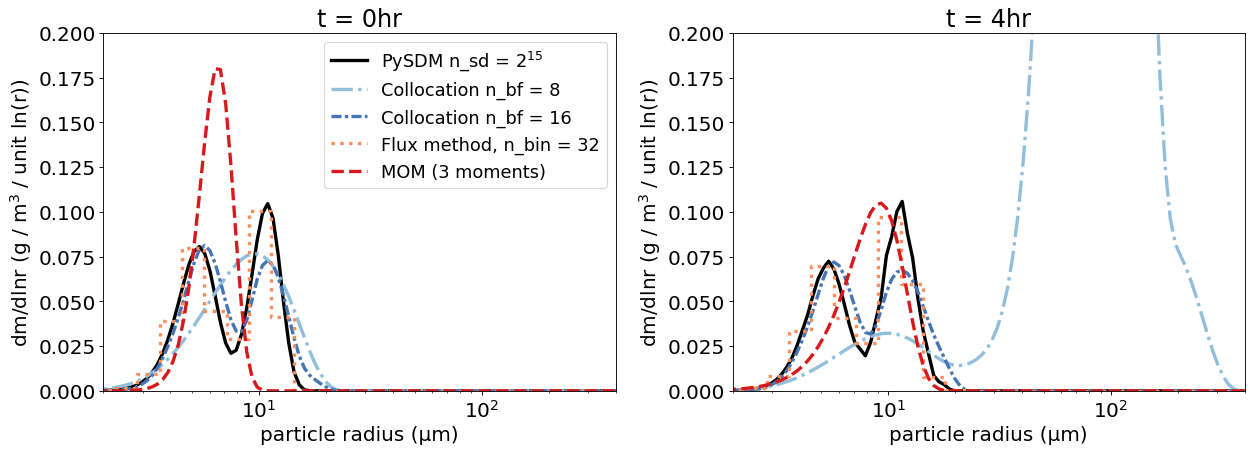

In [15]:
# plot all of them
pyplot.rcParams.update({'font.size':18})
colors = ['#000000','#91bfdb','#4575b4','#fc8d59','#d7191c']
ls = ['-','dashdot',(0, (3, 1, 1, 1)),'dotted','dashed']

fig, ax = pyplot.subplots(nrows=1, ncols=2, figsize=(16,6), dpi=80, facecolor='w', edgecolor='k')

# PySDM sdm_y1: m^3 / m^3 / (unit ln R) --> 1e6 g / m^3 / unit ln R
r_sdm = settings.radius_bins_edges[1:] / si.um
dlnr_sdm = np.log(r_sdm[2]) - np.log(r_sdm[1])

ax[0].plot(r_sdm, sdm_y1[:,0] * 1e6, linestyle=ls[0], color=colors[0], label='PySDM n_sd = $2^{15}$', linewidth=3)
ax[1].plot(r_sdm, sdm_y1[:,-1] * 1e6, linestyle=ls[0], color=colors[0], label='PySDM n_sd = $2^{15}$', linewidth=3)


# COLLOCATION: (um^6 / cm^3) -> 
x = settings.volume_bins_edges[:-1]/si.um**3
yrbf8i = rbf8_i(x)
yrbf8f = rbf8_f(x)
ax[0].plot(r_sdm, 3*x*x*yrbf8i * si.cm**3, linestyle=ls[1],color=colors[1], label='Collocation n_bf = 8',linewidth=3)#, label='Collocation n_bf = 8, init')
ax[1].plot(r_sdm, 3*x*x*yrbf8f * si.cm**3, linestyle=ls[1],color=colors[1], label='Collocation n_bf = 8',linewidth=3)
yrbf16i = rbf16_i(x)
yrbf16f = rbf16_f(x)
ax[0].plot(r_sdm, 3*x*x*yrbf16i * si.cm**3, linestyle=ls[2],color=colors[2], label='Collocation n_bf = 16',linewidth=3)#, label='Collocation n_bf = 16, init')
ax[1].plot(r_sdm, 3*x*x*yrbf16f * si.cm**3, linestyle=ls[2],color=colors[2], label='Collocation n_bf = 16',linewidth=3)

# BIN: (mg / cm^3) / mg
ax[0].step(r_grid_plt,
            gr_0 * si.cm**3,
            linestyle=ls[3],color=colors[3],label='Flux method, n_bin = 32', linewidth=3)#, label='Flux method, n_bin = 32, init')
ax[1].step(r_grid_plt,  
            gr_f * si.cm**3,
            linestyle=ls[3],color=colors[3], label='Flux method, n_bin = 32',linewidth=3)


# BULK: (um^3 / cm^3) / (um^3)
ymomi = mom_i(x)
ymomf = mom_f(x)
ax[0].plot(r_sdm, 3*x*x*ymomi * si.cm**3, linestyle=ls[4],color=colors[4],label="MOM (3 moments)",linewidth=3)#, label="MOM (3 moments), init")
ax[1].plot(r_sdm, 3*x*x*ymomf * si.cm**3, linestyle=ls[4],color=colors[4], label="MOM (3 moments)",linewidth=3)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_xlabel("particle radius (µm)")
#ax[0].set_ylabel("volume density µm$^3$/cm$^3$ per um$^3$")
ax[0].set_ylabel("dm/dlnr (g / m$^3$ / unit ln(r))")
ax[1].set_xlabel("particle radius (µm)")
ax[1].set_ylabel("dm/dlnr (g / m$^3$ / unit ln(r))")
ax[0].set_xlim([2.0, 400.0])
ax[1].set_xlim([2.0, 400.0])
ax[0].set_ylim([0.0, 0.2])
ax[1].set_ylim([0.0, 0.2])
ax[0].legend(fontsize=16)

ax[0].set_title('t = 0hr')
ax[1].set_title('t = 4hr')

ax[0].set_facecolor('white')
ax[1].set_facecolor('white')

#ax[0].grid()
#ax[1].grid()

pyplot.tight_layout()
#pyplot.savefig("m(v)_geometric_bimodal.pdf", transparent=True)

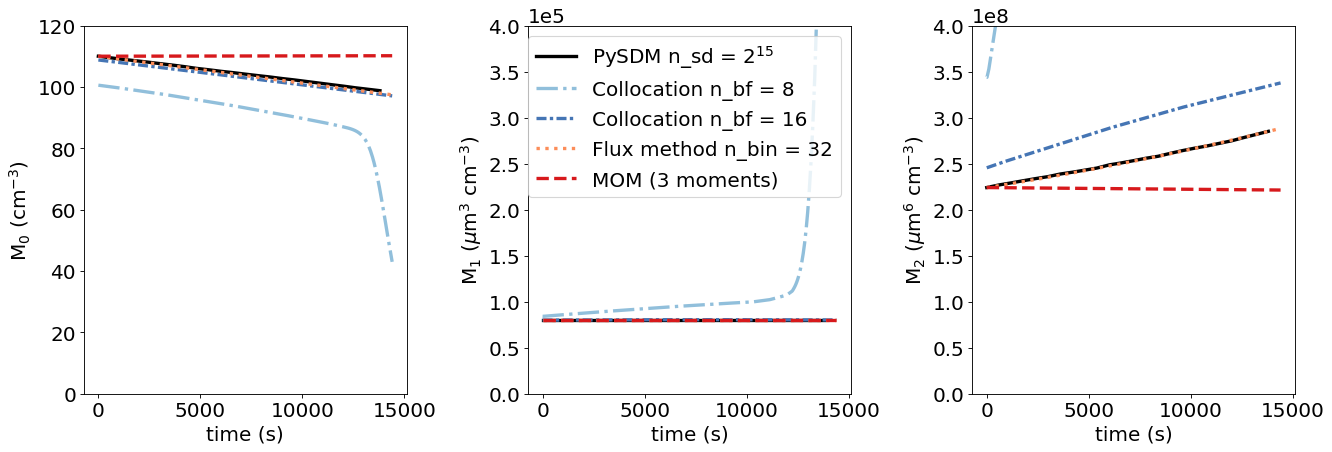

In [16]:
# plot all of them
from matplotlib.ticker import ScalarFormatter
xfmt = ScalarFormatter()
xfmt.set_powerlimits((-3,3))  # Or whatever your limits are . . .

fig, ax = pyplot.subplots(nrows=1, ncols=3, figsize=(17,6), dpi=80, facecolor='w', edgecolor='k')

# PySDM:
ax[0].plot(times_sdm, mom0*si.cm**3, color=colors[0],linestyle=ls[0], label='PySDM', linewidth=3)
ax[1].plot(times_sdm, mom1 / si.um**3 * si.cm**3, color=colors[0],linestyle=ls[0], label='PySDM n_sd = $2^{15}$', linewidth=3)
ax[2].plot(times_sdm, mom2 / si.um**6 * si.cm**3, color=colors[0],linestyle=ls[0], label='PySDM n_sd = $2^{15}$', linewidth=3)

# COLLOCATION:
ax[0].plot(col_8_times, col_8_M_0, color=colors[1],linestyle=ls[1], label='Collocation n_bf = 8',linewidth=3)
ax[1].plot(col_8_times, col_8_M_1, color=colors[1],linestyle=ls[1], label='Collocation n_bf = 8',linewidth=3)
ax[2].plot(col_8_times, col_8_M_2, color=colors[1],linestyle=ls[1], label='Collocation n_bf = 8',linewidth=3)

ax[0].plot(col_16_times, col_16_M_0, color=colors[2],linestyle=ls[2], label='Collocation n_bf = 16',linewidth=3)
ax[1].plot(col_16_times, col_16_M_1, color=colors[2],linestyle=ls[2], label='Collocation n_bf = 16',linewidth=3)
ax[2].plot(col_16_times, col_16_M_2, color=colors[2],linestyle=ls[2], label='Collocation n_bf = 16',linewidth=3)

# BIN: (mg / cm^3) / mg
ax[0].plot(t_bott, M0_bott, color=colors[3],linestyle=ls[3], label='Flux method n_bin = 32',linewidth=3)
ax[1].plot(t_bott, M1_bott, color=colors[3],linestyle=ls[3], label='Flux method n_bin = 32',linewidth=3)
ax[2].plot(t_bott, M2_bott, color=colors[3],linestyle=ls[3], label='Flux method n_bin = 32',linewidth=3)

# # BULK: (um^3 / cm^3) / (um^3)
ax[0].plot(t_cloudy, M0_cloudy, color=colors[4],linestyle=ls[4], label='MOM (3 moments)',linewidth=3)
ax[1].plot(t_cloudy, M1_cloudy, color=colors[4],linestyle=ls[4], label='MOM (3 moments)',linewidth=3)
ax[2].plot(t_cloudy, M2_cloudy, color=colors[4],linestyle=ls[4], label='MOM (3 moments)',linewidth=3)

ax[0].set_xlabel('time (s)')
ax[1].set_xlabel('time (s)')
ax[2].set_xlabel('time (s)')
ax[0].set_ylabel('M$_0$ (cm$^{-3}$)')
ax[1].set_ylabel('M$_1$ ($\mu$m$^3$ cm$^{-3}$)')
ax[2].set_ylabel('M$_2$ ($\mu$m$^6$ cm$^{-3}$)')
ax[0].set_ylim([0, 120])
ax[1].set_ylim([0, 4e5])
ax[2].set_ylim([0, 4e8])
ax[1].legend()
ax[1].yaxis.set_major_formatter(xfmt)

pyplot.tight_layout()
#pyplot.savefig("moments_geometric_bimodal.pdf", transparent=True)


In [17]:
volume_cutoff = 4/3*np.pi*r_cutoff**3

(0.0, 0.001)

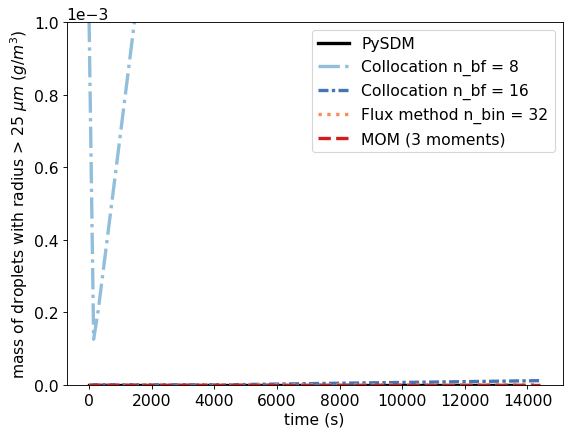

In [18]:
# plot all of them
pyplot.rcParams.update({'font.size':14})
colors = ['#000000','#91bfdb','#4575b4','#fc8d59','#d7191c']
ls = ['-','dashdot',(0, (3, 1, 1, 1)),'dotted','dashed']

pyplot.figure(num=None, figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
pyplot.plot(times_sdm, sdm_precip[:] / 1e6, color=colors[0],linestyle=ls[0], label='PySDM', linewidth=3)
pyplot.plot(t_precip_8, np.divide(m_precip_8, 1e6), color=colors[1], linestyle=ls[1],label='Collocation n_bf = 8',linewidth=3)
pyplot.plot(t_precip_16, np.divide(m_precip_16, 1e6), color=colors[2], linestyle=ls[2],label='Collocation n_bf = 16',linewidth=3)
pyplot.plot(t_bott, np.divide(mprecip_bin, 1e6), color=colors[3], linestyle=ls[3],label='Flux method n_bin = 32',linewidth=3)
pyplot.plot(t_precip_mom, np.divide(m_precip_mom, 1e6), color=colors[4], linestyle=ls[4],label='MOM (3 moments)',linewidth=3)
pyplot.xlabel('time (s)')
pyplot.ylabel('mass of droplets with radius > 25 $\mu m$ $(g / m^3)$')
pyplot.legend()
pyplot.gca().yaxis.set_major_formatter(xfmt)
pyplot.gca().set_ylim([0.0, 0.001])
#pyplot.savefig('m_precip_geometric_bimodal.pdf', transparent=True)

## Error Computation

In [20]:
import pickle

def compute_L2_error(y1, y2):
    return np.linalg.norm(y1-y2)/np.linalg.norm(y2)

def bott_m_f(x):
    mf = np.zeros(len(x))
    dlnr_bin = np.mean(np.log(r_grid[2:]) - np.log(r_grid[1:-1]))
    for i in range(len(x)):
        i0 = find_nearest(v_grid,x[i])[0]
        mf[i] = gr_f[i0]#/dlnr_bin*dlnr
    return mf

v_sdm = x[x < v_cutoff*2]

yrbf8f = rbf8_f(v_sdm)
e8f = compute_L2_error(3*yrbf8f*v_sdm*v_sdm*1e-6, sdm_y1[x < v_cutoff*2,-1]*1e6)

yrbf16f = rbf16_f(v_sdm)
e16f = compute_L2_error(3*yrbf16f*v_sdm*v_sdm*1e-6, sdm_y1[x < v_cutoff*2,-1]*1e6)

ymomf = mom_f(v_sdm)
emomf = compute_L2_error(3*ymomf*v_sdm*v_sdm*1e-6, sdm_y1[x < v_cutoff*2,-1]*1e6)

ybinf = bott_m_f(v_sdm)
ebinf = compute_L2_error(ybinf*1e-6, sdm_y1[x < v_cutoff*2,-1]*1e6)

print(e8f,e16f,emomf,ebinf)
errs = [e8f, e16f, emomf, ebinf]
pickle.dump(errs, open("geometric_bimodal_errors.pkl", "wb" ))

0.7078384370984155 0.29645884696848246 0.6475626673893002 0.26330781875675463
